<a href="https://colab.research.google.com/github/riaddajani/CogSci-Projects-Practice/blob/main/H%26H_PSD_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

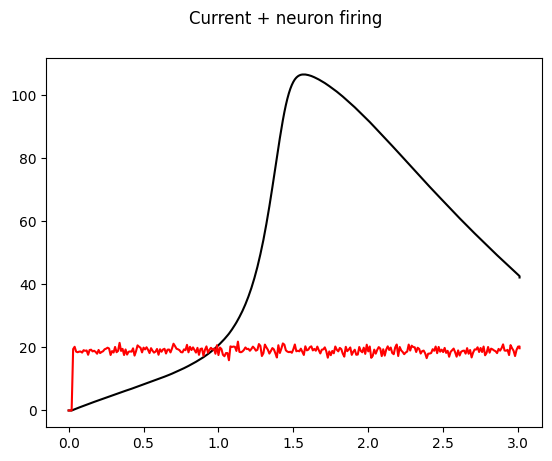

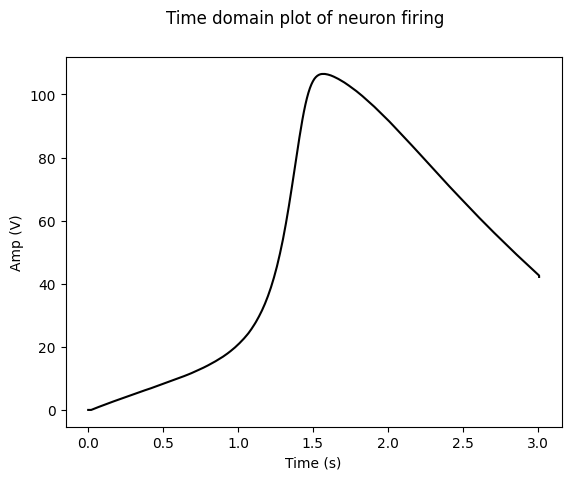

In [1]:
import statistics
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as mp
from math import exp as exp
import pywt
from scipy import fftpack as fftpack

#Variables
deltaT = 0.01
maxT = 3
start = 0
stop = 3
c = 1
v0 = 0
I = 0
thrshld = 3

#Membrane conductances
ena = 115
gna = 120
ek = -12
gk = 36
el = 10.6
gl = 0.30

# H&H Model of the Neuron
def c_volt(V, curr, m, n, h):
	'''dV/dt'''
	return curr-((gna*(m**3)*h*(V-ena))
				+(gk*(n**4)*(V-ek))
				+(gl*(V-el)))

def update(old, deltaT, roc):
	'''Euler's Method'''
	return roc * deltaT + old

def between(start, stop, time):
	'''Activation window'''
	if start < time < stop:
		return True
	elif start < time > stop:
		return False

#Helper alpha/beta functions
def alphaN(volt):
	return (0.01*(10-volt))/(exp((10-volt)/10)-1)

def alphaM(volt):
	return (0.1*(25-volt))/(exp((25-volt)/10)-1)

def alphaH(volt):
	return 0.07*exp(-volt/20)

def betaN(volt):
	return 0.125*exp(-volt/80)

def betaM(volt):
	return 4*exp(-volt/18)

def betaH(volt):
	return 1/(exp((30-volt)/10)+1)

#K, Na & Leak channel probability and dot products
def Ndot(alpha, beta, volt, n):
	return (alpha)*(1-n)-((beta)*n)

def Mdot(alpha, beta, volt, m):
	return (alpha)*(1-m)-((beta)*m)

def Hdot(alpha, beta, volt, h):
	return (alpha)*(1-h)-((beta)*h)

def Ninf(alpha, beta, volt):
	return (alpha)/((alpha)+(beta))

def Minf(alpha, beta, volt):
	return (alpha)/((alpha)+(beta))

def Hinf(alpha, beta, volt):
	return (alpha)/((alpha)+(beta))

#Simulate HandH
def fire(initvolt):
	'''INITIALIZE'''
	time = [0]
	vs = [initvolt]
	currents = [0]
	nA = alphaN(vs[-1])
	mA = alphaM(vs[-1])
	hA = alphaH(vs[-1])
	nB = betaN(vs[-1])
	mB = betaM(vs[-1])
	hB = betaH(vs[-1])
	ns = [Ninf(nA, nB, vs[-1])]
	ms = [Minf(mA, mB, vs[-1])]
	hs = [Hinf(hA, hB, vs[-1])]

	'''SIMULATE'''
	while time[-1] < maxT:
		I = 0
		noise = np.random.normal(-1,1,stop-start)
		if between(start, stop, time[-1]) == True:
			I = 20 + noise[-1]
			dv = c_volt(vs[-1], I, ms[-1], ns[-1], hs[-1])
			now_volt = update(vs[-1], deltaT, dv)
		else:
			dv = c_volt(vs[-1], I, ms[-1], ns[-1], hs[-1])
			now_volt = update(vs[-1], deltaT, dv)
		nA = alphaN(vs[-1])
		mA = alphaM(vs[-1])
		hA = alphaH(vs[-1])
		nB = betaN(vs[-1])
		mB = betaM(vs[-1])
		hB = betaH(vs[-1])
		ndot = Ndot(nA, nB, vs[-1], ns[-1])
		mdot = Mdot(mA, mB, vs[-1], ms[-1])
		hdot = Hdot(hA, hB, vs[-1], hs[-1])
		ns.append(update(ns[-1], deltaT, ndot))
		ms.append(update(ms[-1], deltaT, mdot))
		hs.append(update(hs[-1], deltaT, hdot))
		vs.append(now_volt)
		currents.append(I)
		time[-1] += deltaT
		time.append(time[-1])
	return vs, time, currents

vs, time, currents = fire(v0)
time[0] = 0
currents[0] = 0

mp.plot(time, vs, 'black', label = "Neuron Firing")
mp.plot(time, currents, 'r', label = "Current injection")
mp.suptitle("Current + neuron firing")
mp.show()

mp.plot(time, vs, 'black', label = "Neuron Firing")
mp.ylabel("Amp (V)")
mp.xlabel("Time (s)")
mp.suptitle("Time domain plot of neuron firing")
mp.show()

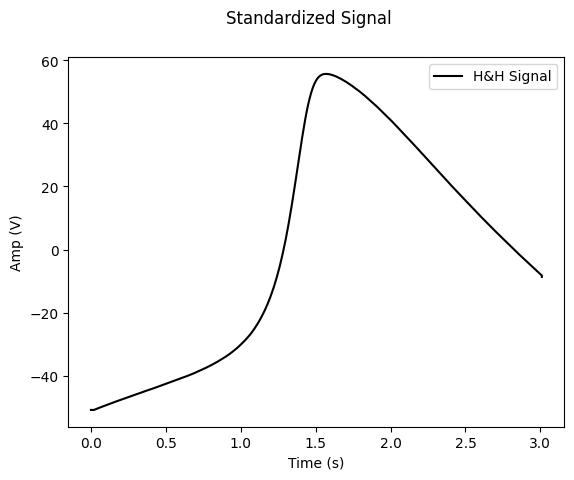

In [2]:
# Data formatting
vs_mean = statistics.mean(vs)
signal = [v - vs_mean for v in vs]
signal = signal

mp.figure()
mp.plot(time, signal, 'black', label = "H&H Signal")
mp.ylabel("Amp (V)")
mp.xlabel("Time (s)")
mp.suptitle("Standardized Signal")
mp.legend()
mp.show()

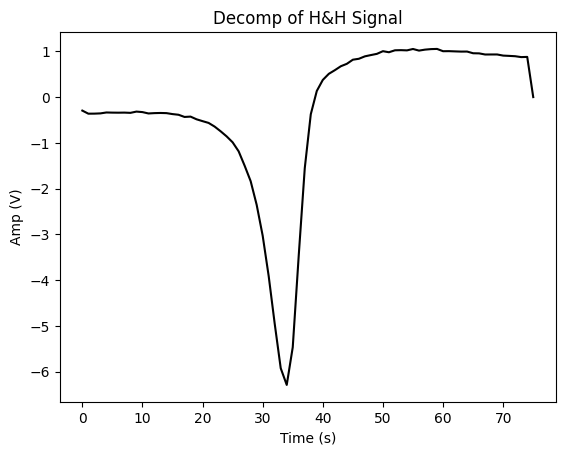

In [3]:
# Decomposition
def decompose_signal(signal, wavelet='db1', level=2):
    '''Decompose signal into its frequency components using DWT algorithm'''
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

signal_coeffs = decompose_signal(signal)
ts = range(len(signal_coeffs[1]))
signal_coeffs0 = signal_coeffs[1]

mp.figure()
mp.plot(ts, signal_coeffs0, 'black', label = "Decomp H&H Signal")
mp.xlabel('Time (s)')
mp.ylabel("Amp (V)")
mp.title('Decomp of H&H Signal')
mp.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


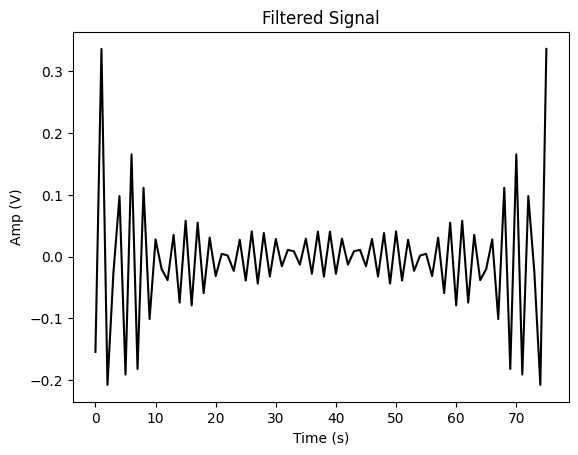

In [4]:
# Feature extraction
def filter_eeg_data(eeg_fft):
    '''Filters an EEG signal in the frequency domain'''
    Amp_eeg = np.abs(eeg_fft)

    sample_freq_eeg = fftpack.fftfreq(np.asarray(eeg_fft).size)
    Amp_Freq_eeg = np.array([Amp_eeg, sample_freq_eeg])
    Amp_pos_eeg = Amp_Freq_eeg[0,:].argmax()
    peak_freq_eeg = Amp_Freq_eeg[1, Amp_pos_eeg]

    hf_fft = eeg_fft.copy()
    hf_fft[np.abs(sample_freq_eeg) > peak_freq_eeg] = 0
    filtered_eeg = fftpack.ifft(hf_fft)

    return filtered_eeg

signal_fe = filter_eeg_data(signal_coeffs0)

mp.figure()
mp.plot(ts, signal_fe, 'black', label = "Filtered Signal")
mp.xlabel('Time (s)')
mp.ylabel("Amp (V)")
mp.title('Filtered Signal')
mp.show()

The frequency of the wave is 44.74 Hz
The max frequency of the PSD is 44.74 Hz


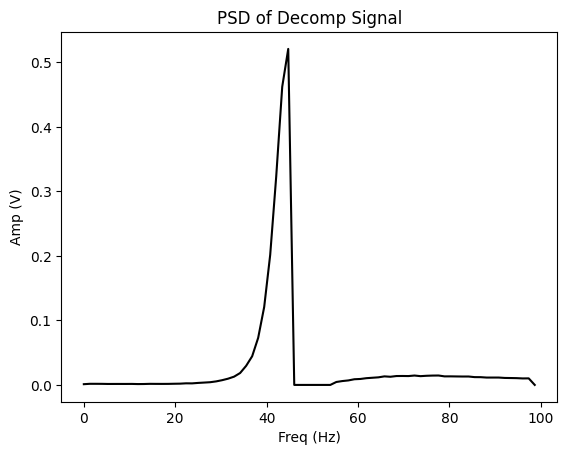

In [5]:


# PSD of signal https://www.earthinversion.com/techniques/signal-denoising-using-fast-fourier-transform/
def fft(signal, threshold=100):
	'''Calculate the Fourier transform of a signal'''
	n = len(signal)
	fourier = np.fft.fft(signal, n)
	psd = fourier * np.conj(fourier) / n
	freq = (1/(deltaT*n)) * np.arange(n)
	psd_idxs = psd < threshold
	psd_clean = psd * psd_idxs

	return freq, psd_clean

freq, psd_clean = fft(signal_fe)

# print frequenct of signal_fe to check if PSD is correct
def print_wave_frequency(signal, sampling_rate):
	'''Print the frequency of the wave in the signal'''
	n = len(signal)
	fourier = np.fft.fft(signal, n)
	freq = (1/(sampling_rate*n)) * np.arange(n)
	max_freq_idx = np.argmax(np.abs(fourier[:n//2]))
	wave_freq = freq[max_freq_idx]
	print(f"The frequency of the wave is {wave_freq:.2f} Hz")

print_wave_frequency(signal_fe, deltaT)

def maxHz(psd, hz):
	'''Find the max frequency of the PSD'''
	maxHz = 0
	maxPSD = 0
	for i, num in enumerate(psd):
		if num > maxPSD:
			maxPSD = num
			maxHz = hz[i]
	return maxHz

print(f"The max frequency of the PSD is {maxHz(psd_clean, freq):.2f} Hz")

mp.figure()
mp.plot(freq, psd_clean, 'black', label = "PSD")
mp.xlabel('Freq (Hz)')
mp.ylabel("Amp (V)")
mp.title('PSD of Decomp Signal')
mp.show()

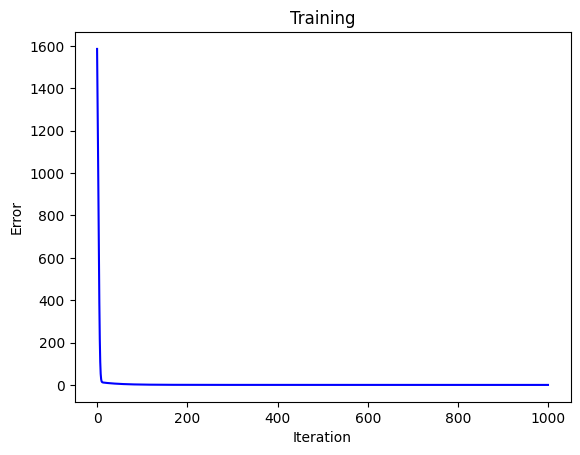

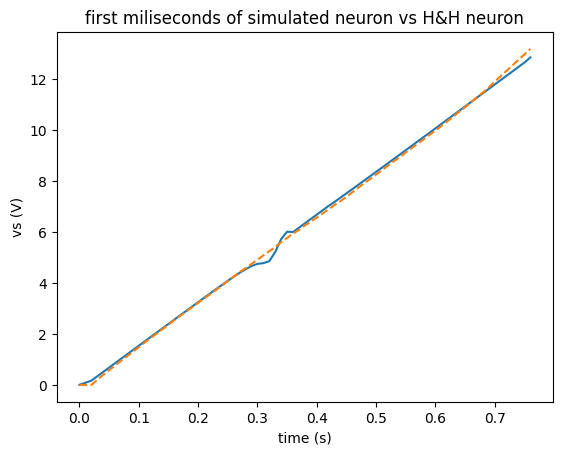

In [6]:
# Data formatting for NN
def create_2d_array(arr1, arr2):
    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length")
    return np.column_stack((arr1, arr2))

X = create_2d_array(psd_clean, freq)
def rescale_data(data):
    def scale_column(column):
        min_val = np.min(column)
        max_val = np.max(column)
        return (column - min_val) / (max_val - min_val)

    scaled_data = np.copy(data)
    for i in range(data.shape[1]):
        scaled_data[:, i] = scale_column(data[:, i])
    return scaled_data

X = rescale_data(X)
Y = np.array(vs[:len(psd_clean)]).reshape(-1, 1)

class NN(object):
	def __init__(self):
		self.inputSize = 2
		self.outputSize = 1
		self.hiddenLayer = 12
		self.hiddenLayer2 = 6

		self.W1 = self.he_init((self.inputSize, self.hiddenLayer))
		self.W2 = self.he_init((self.hiddenLayer, self.hiddenLayer2))
		self.W3 = self.he_init((self.hiddenLayer2, self.outputSize))

	def he_init(self, shape):
		stddev = np.sqrt(2/shape[0])
		return np.random.normal(loc=0, scale=stddev, size=shape)

	def cost(self, X, Y):
		self.yH = self.fforward(X)
		return sum((Y-self.yH)**2)*1/2

	def costP(self, X, Y):
		self.yH = self.fforward(X)
		d4 = -(Y - self.yH)
		costW3 = np.dot(self.a3.T, d4)
		d3 = np.dot(d4, self.W3.T) * self.reluP(self.z3)
		costW2 = np.dot(self.a2.T, d3)
		d2 = np.dot(d3, self.W2.T) * self.reluP(self.z2)
		costW1 = np.dot(X.T, d2)
		return costW1, costW2, costW3

	# ReLU activation and its derivative
	def relu(self, z):
		return np.maximum(0, z)

	def reluP(self, z):
		return np.where(z > 0, 1, 0)

	def sig(self, z):
		return 1/(1+np.exp(-z))

	def sigP(self, z):
		return np.exp(-z)/((1+np.exp(-z))**2)

	def fforward(self, x):
		self.z2 = np.dot(x, self.W1)
		self.a2 = self.relu(self.z2)
		self.z3 = np.dot(self.a2, self.W2)
		self.a3 = self.relu(self.z3)
		self.z4 = np.dot(self.a3, self.W3)
		yH = self.z4  # No activation for the output layer
		return yH


NN_relu = NN()
error = []
iteration = []
trainSize = 1000
for i in range(trainSize):
	J1 = NN_relu.cost(X, Y)
	t = 0.0001
	costW1, costW2, costW3 = NN_relu.costP(X, Y)
	NN_relu.W1 = NN_relu.W1 - t * costW1
	NN_relu.W2 = NN_relu.W2 - t * costW2
	NN_relu.W3 = NN_relu.W3 - t * costW3
	J2 = NN_relu.cost(X,Y)
	costW1, costW2, costW3 = NN_relu.costP(X, Y)
	NN_relu.W1 = NN_relu.W1 - t * costW1
	NN_relu.W2 = NN_relu.W2 - t * costW2
	NN_relu.W3 = NN_relu.W3 - t * costW3
	J3 = NN_relu.cost(X,Y)

	yH = NN_relu.fforward(X)
	error.append(J3)
	iteration.append(i)
	if (i == trainSize):
		break

mp.plot(iteration, error, color='blue')
mp.xlabel('Iteration')
mp.ylabel('Error')
mp.title('Training')
mp.show()

# Still trying to optimize so that error == 0
mp.figure()
mp.plot(time[:len(yH.real)], yH.real, label = "Simulated NN Neuron")
mp.plot(time[:len(yH.real)], vs[:len(yH.real)], linestyle='--', label = "H&H Neuron")
mp.xlabel('time (s)')
mp.ylabel("vs (V)")
mp.title('first miliseconds of simulated neuron vs H&H neuron')
mp.show()